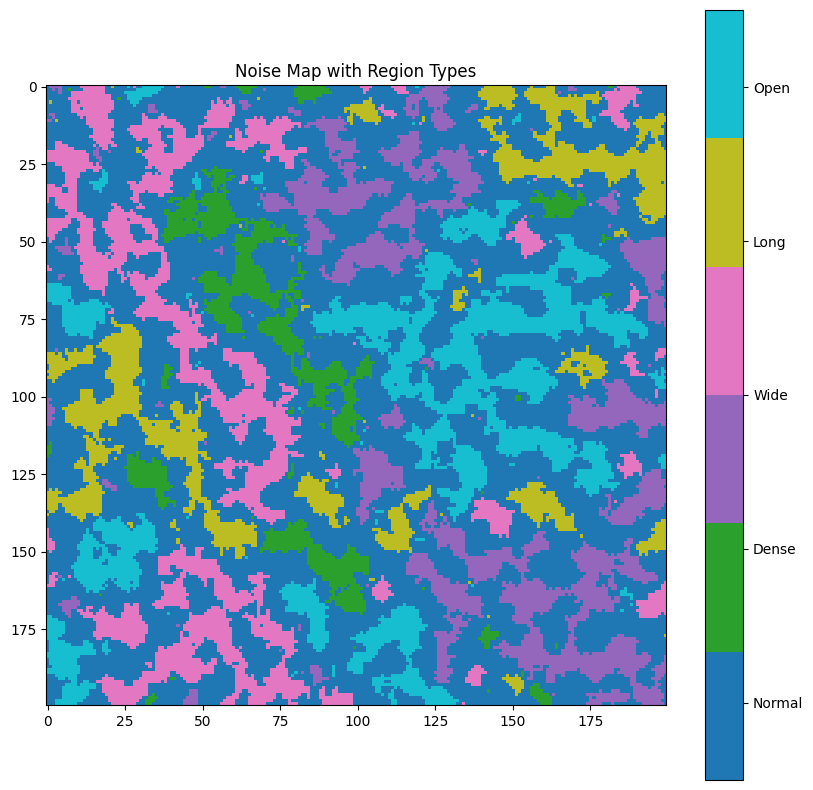

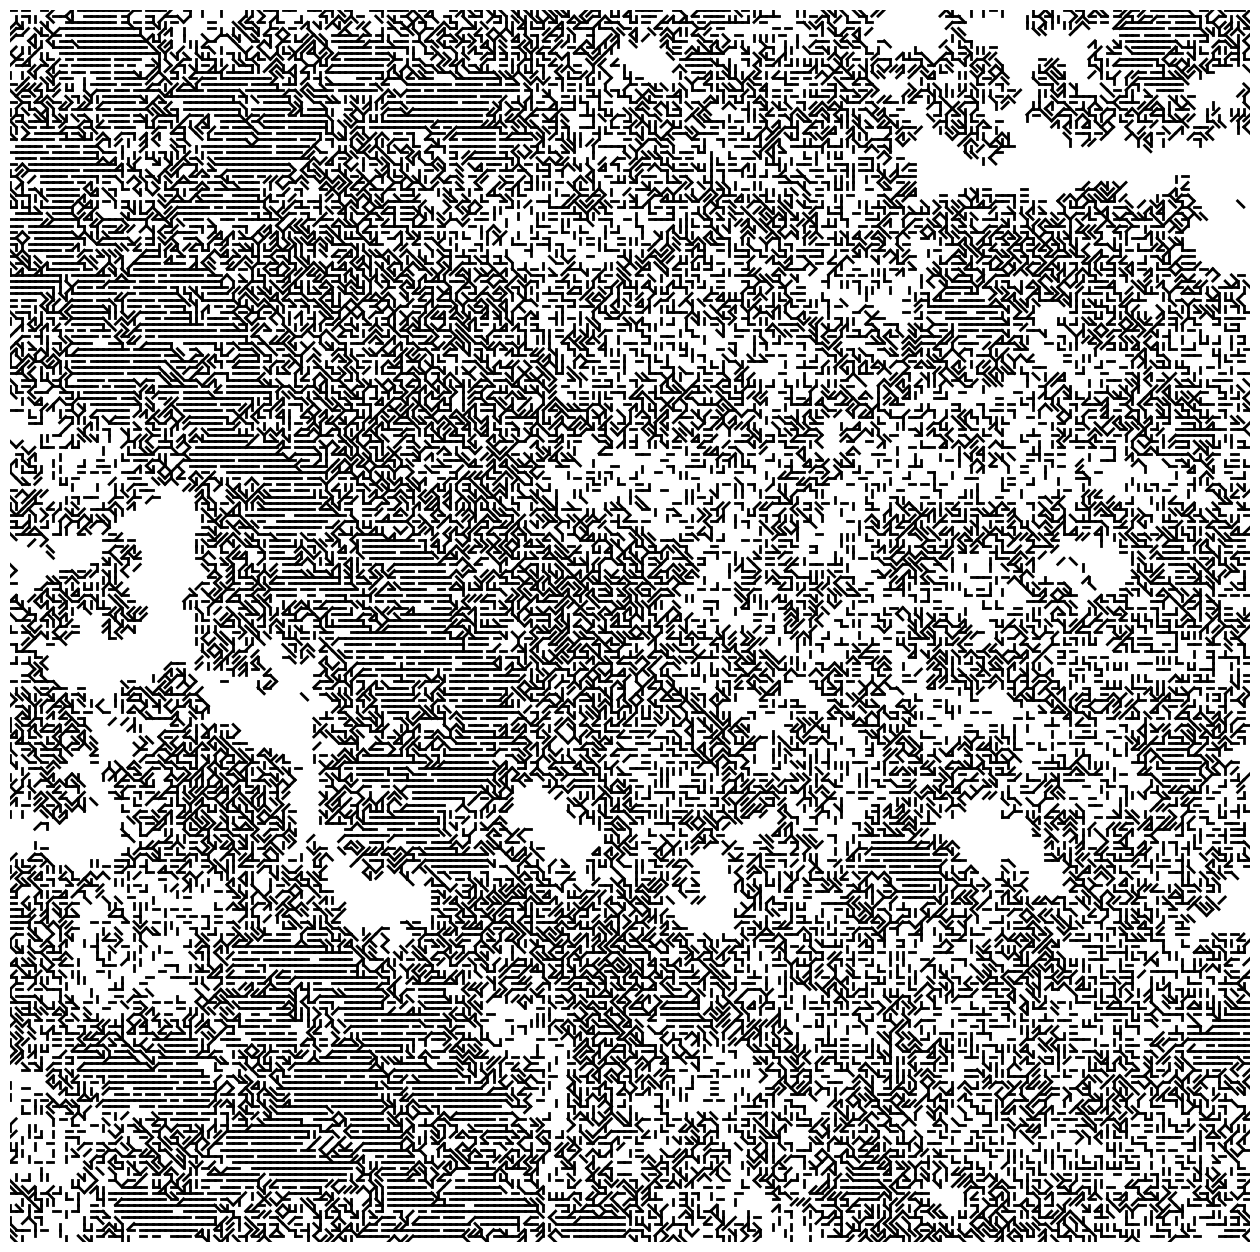

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, label
from scipy.interpolate import splprep, splev
from noise import pnoise2

# Define the states for each cell
NO_WALL = 0
HORIZONTAL_WALL = 1
VERTICAL_WALL = 2
SLASH_FORWARD_WALL = 3
SLASH_BACKWARD_WALL = 4

# Maze dimensions
width, height = 200, 200

# Define region types
NORMAL = 0
DENSE = 1
WIDE = 2
LONG = 3
OPEN = 4
EXTRA_WIDE = 5

# Parameters for Perlin noise
octaves = 5
scale = 10.0
persistence = 0.5
lacunarity = 2.0

# Generate Perlin noise map
perlin_noise_map = np.zeros((height, width))
for y in range(height):
    for x in range(width):
        perlin_noise_map[y][x] = pnoise2(
            x / scale,
            y / scale,
            octaves=octaves,
            persistence=persistence,
            lacunarity=lacunarity,
            repeatx=width,
            repeaty=height,
            base=42,
        )

# Normalize Perlin noise to range between 0 and 1
perlin_noise_map = (perlin_noise_map - perlin_noise_map.min()) / (
    perlin_noise_map.max() - perlin_noise_map.min()
)

# Assign regions based on Perlin noise values
noise_map = np.full((height, width), NORMAL)  # Default all to NORMAL

# Label connected clusters in the Perlin noise map
clusters, num_clusters = label(perlin_noise_map < 0.5)

# Randomly assign a region type to each cluster
for cluster_num in range(1, num_clusters + 1):
    region_type = np.random.choice([DENSE, WIDE, LONG, OPEN, EXTRA_WIDE])
    noise_map[clusters == cluster_num] = region_type


# Function to generate walls based on the region type
def generate_walls_for_region(region_type):
    if region_type == NORMAL:
        return np.random.choice(
            [
                NO_WALL,
                HORIZONTAL_WALL,
                VERTICAL_WALL,
                SLASH_FORWARD_WALL,
                SLASH_BACKWARD_WALL,
            ],
            p=[0.2, 0.2, 0.2, 0.2, 0.2],
        )
    elif region_type == DENSE:
        return np.random.choice(
            [HORIZONTAL_WALL, VERTICAL_WALL, SLASH_FORWARD_WALL, SLASH_BACKWARD_WALL],
            p=[0.25, 0.25, 0.25, 0.25],
        )
    elif region_type == WIDE:
        return np.random.choice(
            [NO_WALL, HORIZONTAL_WALL, VERTICAL_WALL], p=[0.5, 0.25, 0.25]
        )
    elif region_type == LONG:
        return np.random.choice([NO_WALL, HORIZONTAL_WALL], p=[0.1, 0.9])
    elif region_type == OPEN:
        return NO_WALL
    elif region_type == EXTRA_WIDE:
        return np.random.choice(
            [NO_WALL, HORIZONTAL_WALL, VERTICAL_WALL], p=[0.7, 0.15, 0.15]
        )


# Function to draw the maze based on wall types
def draw_maze(maze):
    plt.figure(figsize=(16, 16))
    for y in range(height):
        for x in range(width):
            if maze[y, x] == HORIZONTAL_WALL:
                plt.plot(
                    [x, x + 1], [y, y], color="black", linewidth=2
                )  # horizontal line
            elif maze[y, x] == VERTICAL_WALL:
                plt.plot(
                    [x, x], [y, y + 1], color="black", linewidth=2
                )  # vertical line
            elif maze[y, x] == SLASH_FORWARD_WALL:
                plt.plot(
                    [x, x + 1], [y, y + 1], color="black", linewidth=2
                )  # forward slash
            elif maze[y, x] == SLASH_BACKWARD_WALL:
                plt.plot(
                    [x + 1, x], [y, y + 1], color="black", linewidth=2
                )  # backward slash
    plt.xlim(0, width)
    plt.ylim(0, height)
    plt.gca().invert_yaxis()
    plt.axis("off")
    plt.show()


# Function to display the noise map with labels and colors
def display_noise_map(noise_map):
    cmap = plt.get_cmap("tab10", 6)  # 6 unique colors for 6 regions
    plt.figure(figsize=(10, 10))
    plt.imshow(noise_map, cmap=cmap, origin="upper")

    # Add a color bar with labels for each region type
    cbar = plt.colorbar(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
    cbar.ax.set_yticklabels(["Normal", "Dense", "Wide", "Long", "Open", "Extra Wide"])

    plt.title("Noise Map with Region Types")
    plt.show()


# Generate the maze using the noise map to define wall types
maze = np.zeros((height, width), dtype=int)
for y in range(height):
    for x in range(width):
        maze[y, x] = generate_walls_for_region(noise_map[y, x])

# Display the noise map and the generated maze
display_noise_map(noise_map)
draw_maze(maze)

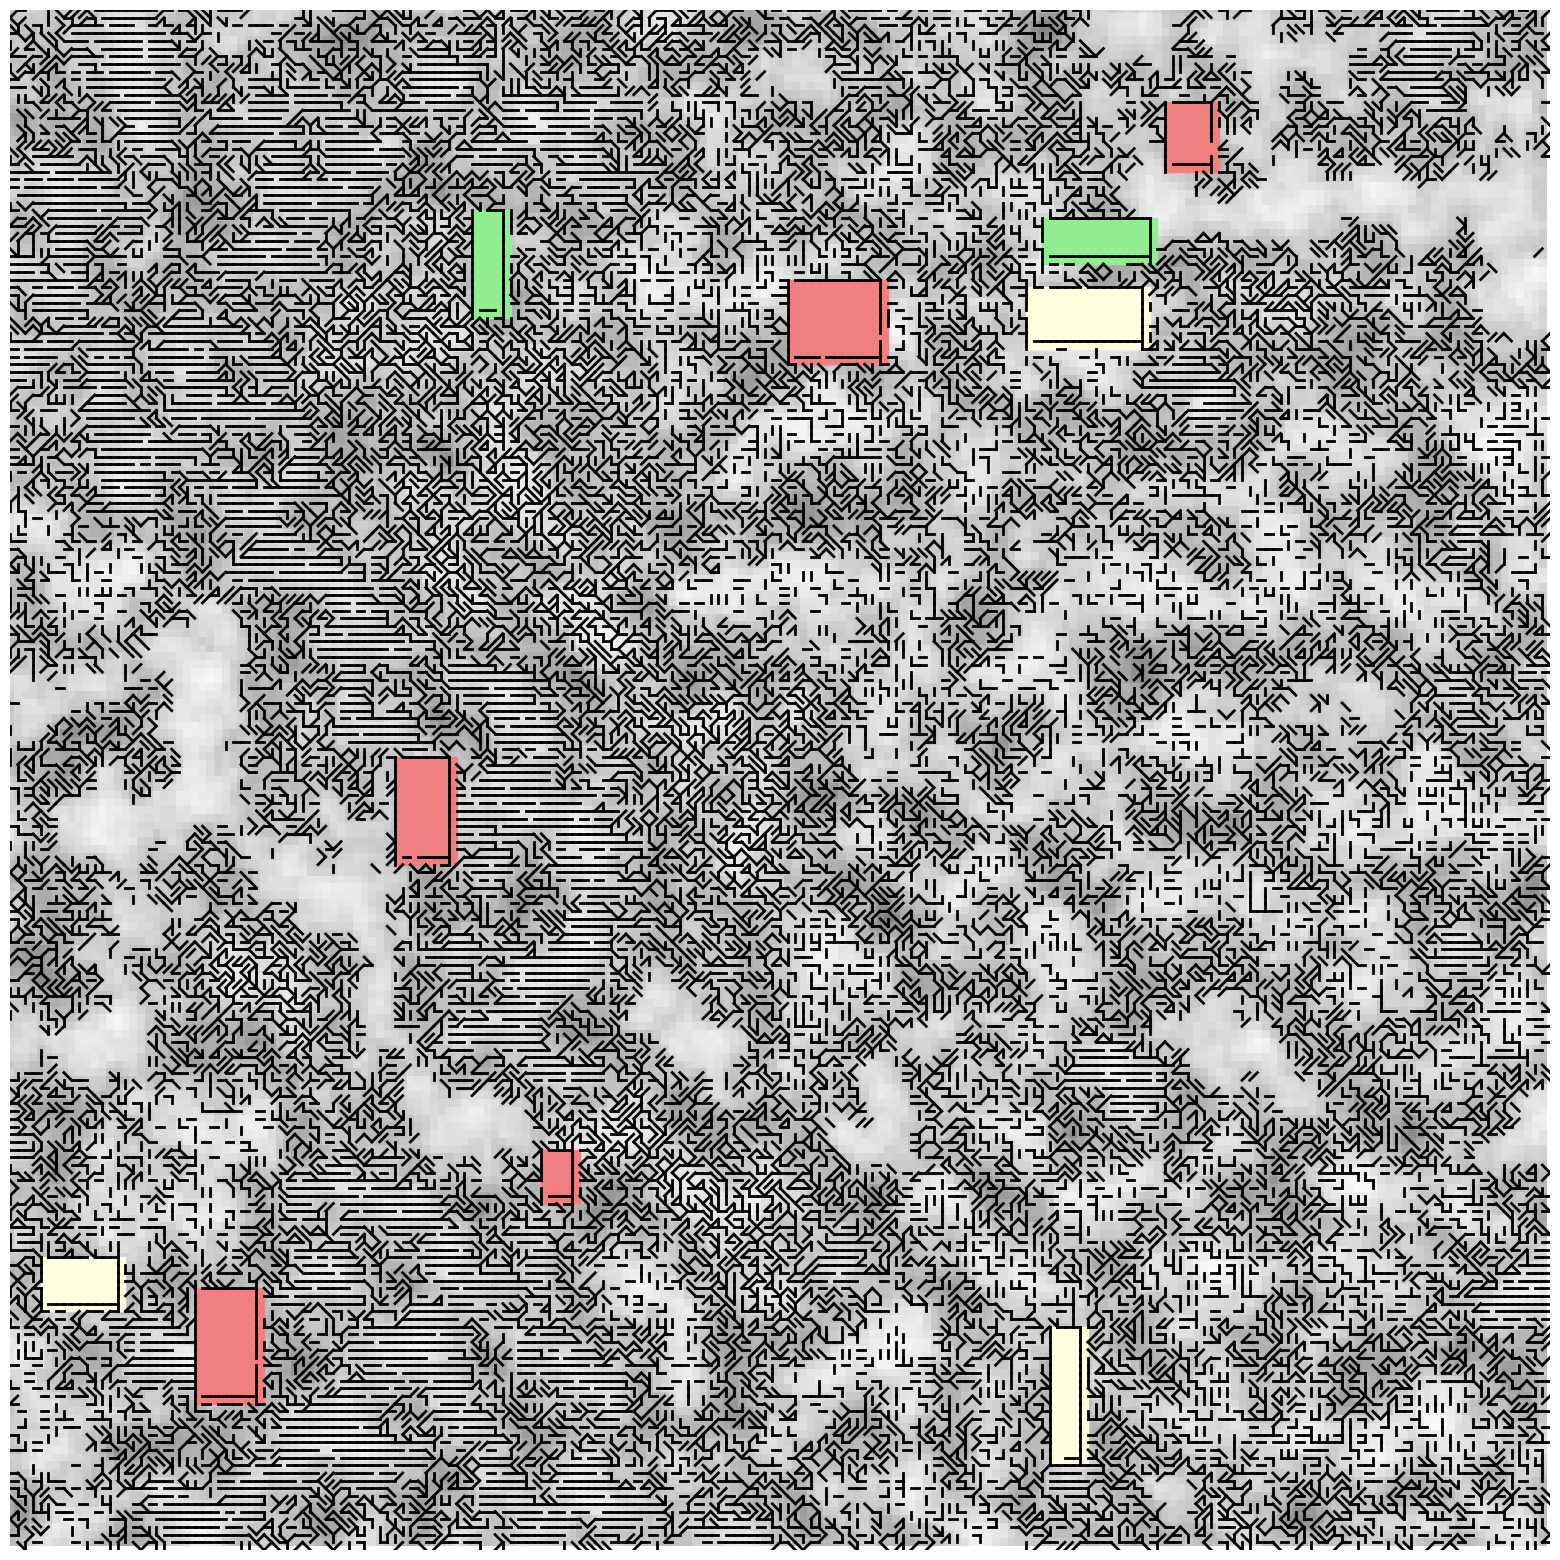

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Room parameters
num_rooms = 10  # Number of rooms
min_room_size = 5
max_room_size = 20

# Lighter versions of red, yellow, and green
light_colors = ["lightcoral", "lightyellow", "lightgreen"]


# Function to add rooms with walls and random openings
def add_random_rooms_with_openings(maze, num_rooms):
    rooms = []
    color_choices = ["lightcoral"] * 3 + ["lightyellow"] + ["lightgreen"]  # 3:1:1 ratio
    for _ in range(num_rooms):
        room_w = np.random.randint(min_room_size, max_room_size)
        room_h = np.random.randint(min_room_size, max_room_size)
        room_x = np.random.randint(1, width - room_w - 1)
        room_y = np.random.randint(1, height - room_h - 1)

        # Pick a random color for the room based on the ratio
        room_color = np.random.choice(color_choices)

        # Add room to rooms list
        rooms.append((room_x, room_y, room_w, room_h, room_color))

        # Enclose room with walls, leaving inside empty
        maze[room_y, room_x : room_x + room_w] = 1  # Top wall
        maze[room_y + room_h - 1, room_x : room_x + room_w] = 1  # Bottom wall
        maze[room_y : room_y + room_h, room_x] = 2  # Left vertical wall
        maze[room_y : room_y + room_h, room_x + room_w - 1] = 2  # Right vertical wall

        # Clear inside of the room (empty)
        maze[room_y + 1 : room_y + room_h - 1, room_x + 1 : room_x + room_w - 1] = 0

        # Bell curve probability for number of openings (1 to 5)
        openings = np.random.choice([1, 2, 3, 4, 5], p=[0.4, 0.3, 0.15, 0.1, 0.05])

        # Create openings on random walls
        for _ in range(openings):
            side = np.random.choice(["top", "bottom", "left", "right"])
            if side == "top":
                maze[room_y, np.random.randint(room_x + 1, room_x + room_w - 1)] = 0
            elif side == "bottom":
                maze[
                    room_y + room_h - 1,
                    np.random.randint(room_x + 1, room_x + room_w - 1),
                ] = 0
            elif side == "left":
                maze[np.random.randint(room_y + 1, room_y + room_h - 1), room_x] = 0
            elif side == "right":
                maze[
                    np.random.randint(room_y + 1, room_y + room_h - 1),
                    room_x + room_w - 1,
                ] = 0

    return rooms


# Function to draw the maze with colored rooms and noise map background
def draw_maze_with_rooms_and_noise(maze, rooms, noise_map):
    plt.figure(figsize=(20, 20))

    # Display the noise map as the background
    plt.imshow(noise_map, cmap="Greys", origin="upper", alpha=0.5)

    for room_x, room_y, room_w, room_h, room_color in rooms:
        # Draw the room background with its color
        plt.gca().add_patch(
            plt.Rectangle((room_x, room_y), room_w, room_h, color=room_color, zorder=0)
        )

    for y in range(height):
        for x in range(width):
            if maze[y, x] == HORIZONTAL_WALL:
                plt.plot(
                    [x, x + 1], [y, y], color="black", linewidth=2, zorder=1
                )  # horizontal line
            elif maze[y, x] == VERTICAL_WALL:
                plt.plot(
                    [x, x], [y, y + 1], color="black", linewidth=2, zorder=1
                )  # vertical line
            elif maze[y, x] == SLASH_FORWARD_WALL:
                plt.plot(
                    [x, x + 1], [y, y + 1], color="black", linewidth=2, zorder=1
                )  # forward slash
            elif maze[y, x] == SLASH_BACKWARD_WALL:
                plt.plot(
                    [x + 1, x], [y, y + 1], color="black", linewidth=2, zorder=1
                )  # backward slash

    plt.xlim(0, width)
    plt.ylim(0, height)
    plt.gca().invert_yaxis()
    plt.axis("off")
    plt.show()


# Generate the Perlin-based maze (from your previous code)
maze = np.zeros((height, width), dtype=int)
for y in range(height):
    for x in range(width):
        maze[y, x] = generate_walls_for_region(noise_map[y, x])

# Add random rooms with walls and openings
rooms = add_random_rooms_with_openings(maze, num_rooms)

# Display the final maze with noise map background and colored rooms
draw_maze_with_rooms_and_noise(maze, rooms, perlin_noise_map)

In [18]:
import pygame
import numpy as np
from noise import pnoise2
from scipy.ndimage import label

# Initialize Pygame
pygame.init()

# Maze parameters
width, height = 200, 200
zoom_scale = 20
screen_width, screen_height = 600, 600
player_radius = 4
player_speed = 100  # Movement speed in pixels per second

# Define wall types
NO_WALL = 0
HORIZONTAL_WALL = 1
VERTICAL_WALL = 2
SLASH_FORWARD_WALL = 3
SLASH_BACKWARD_WALL = 4

# Define region types
NORMAL = 0
DENSE = 1
WIDE = 2
LONG = 3
OPEN = 4
EXTRA_WIDE = 5

# Set up the screen
screen = pygame.display.set_mode((screen_width, screen_height))
pygame.display.set_caption("Maze Game")

# Toggle for showing/hiding collision lines and grid
show_collision_lines = False
show_grid = False  # Toggle the grid


# Function to check if a position is valid (not too close to a wall line)
def is_valid_position(x, y, maze, zoom_scale):
    maze_x = int(x / zoom_scale)
    maze_y = int(y / zoom_scale)
    if 0 <= maze_x < width and 0 <= maze_y < height:
        if maze[maze_y, maze_x] == NO_WALL:
            return True, None  # No collision

        # Horizontal wall check: Collide if player is near the top of the tile.
        if maze[maze_y, maze_x] == HORIZONTAL_WALL:
            wall_y = maze_y * zoom_scale  # Wall is at the top of the tile
            if abs(y - wall_y) < player_radius:
                return False, (maze_x, maze_y, HORIZONTAL_WALL)

        # Vertical wall check: Collide if player is near the left of the tile.
        if maze[maze_y, maze_x] == VERTICAL_WALL:
            wall_x = maze_x * zoom_scale  # Wall is at the left of the tile
            if abs(x - wall_x) < player_radius:
                return False, (maze_x, maze_y, VERTICAL_WALL)

        # Forward slash wall (/): Collision along the diagonal line (top-right to bottom-left).
        if maze[maze_y, maze_x] == SLASH_FORWARD_WALL:
            wall_y = (maze_y + 1) * zoom_scale - (x % zoom_scale)
            if abs(y - wall_y) < player_radius:
                return False, (maze_x, maze_y, SLASH_FORWARD_WALL)

        # Backward slash wall (\): Collision along the diagonal line (top-left to bottom-right).
        if maze[maze_y, maze_x] == SLASH_BACKWARD_WALL:
            wall_y = maze_y * zoom_scale + (x % zoom_scale)
            if abs(y - wall_y) < player_radius:
                return False, (maze_x, maze_y, SLASH_BACKWARD_WALL)

    return True, None  # No collision or out of bounds


# Player settings (initial valid spawn position)
player_pos = [screen_width // 2, screen_height // 2]
collision_point = None

player_color = (0, 0, 255)
collision_color = (255, 0, 0)  # Red for collision box

# Generate Perlin noise map
octaves = 5
scale = 10.0
persistence = 0.5
lacunarity = 2.0
perlin_noise_map = np.zeros((height, width))

for y in range(height):
    for x in range(width):
        perlin_noise_map[y, x] = pnoise2(
            x / scale,
            y / scale,
            octaves=octaves,
            persistence=persistence,
            lacunarity=lacunarity,
            base=42,
        )

# Normalize Perlin noise
perlin_noise_map = (perlin_noise_map - perlin_noise_map.min()) / (
    perlin_noise_map.max() - perlin_noise_map.min()
)

# Assign regions based on Perlin noise
noise_map = np.full((height, width), NORMAL)
clusters, num_clusters = label(perlin_noise_map < 0.5)
for cluster_num in range(1, num_clusters + 1):
    region_type = np.random.choice([DENSE, WIDE, LONG, OPEN, EXTRA_WIDE])
    noise_map[clusters == cluster_num] = region_type


# Function to generate walls based on region type
def generate_walls_for_region(region_type):
    if region_type == NORMAL:
        return np.random.choice(
            [
                NO_WALL,
                HORIZONTAL_WALL,
                VERTICAL_WALL,
                SLASH_FORWARD_WALL,
                SLASH_BACKWARD_WALL,
            ],
            p=[0.5, 0.15, 0.15, 0.1, 0.1],
        )
    elif region_type == DENSE:
        return np.random.choice(
            [HORIZONTAL_WALL, VERTICAL_WALL, SLASH_FORWARD_WALL, SLASH_BACKWARD_WALL],
            p=[0.25, 0.25, 0.25, 0.25],
        )
    elif region_type == WIDE:
        return np.random.choice(
            [NO_WALL, HORIZONTAL_WALL, VERTICAL_WALL], p=[0.7, 0.15, 0.15]
        )
    elif region_type == LONG:
        return np.random.choice([NO_WALL, HORIZONTAL_WALL], p=[0.1, 0.9])
    elif region_type == OPEN:
        return NO_WALL
    elif region_type == EXTRA_WIDE:
        return np.random.choice(
            [NO_WALL, HORIZONTAL_WALL, VERTICAL_WALL], p=[0.7, 0.15, 0.15]
        )


# Generate the maze
maze = np.zeros((height, width), dtype=int)
for y in range(height):
    for x in range(width):
        maze[y, x] = generate_walls_for_region(noise_map[y, x])


# Function to draw the maze
def draw_maze(maze, zoom_scale, offset_x, offset_y):
    for y in range(height):
        for x in range(width):
            color = (0, 0, 0)
            if maze[y, x] == HORIZONTAL_WALL:
                pygame.draw.line(
                    screen,
                    color,
                    (x * zoom_scale + offset_x, y * zoom_scale + offset_y),
                    (x * zoom_scale + zoom_scale + offset_x, y * zoom_scale + offset_y),
                    2,
                )
            elif maze[y, x] == VERTICAL_WALL:
                pygame.draw.line(
                    screen,
                    color,
                    (x * zoom_scale + offset_x, y * zoom_scale + offset_y),
                    (x * zoom_scale + offset_x, y * zoom_scale + zoom_scale + offset_y),
                    2,
                )
            elif maze[y, x] == SLASH_FORWARD_WALL:
                pygame.draw.line(
                    screen,
                    color,
                    (x * zoom_scale + zoom_scale + offset_x, y * zoom_scale + offset_y),
                    (x * zoom_scale + offset_x, y * zoom_scale + zoom_scale + offset_y),
                    2,
                )
            elif maze[y, x] == SLASH_BACKWARD_WALL:
                pygame.draw.line(
                    screen,
                    color,
                    (x * zoom_scale + offset_x, y * zoom_scale + offset_y),
                    (
                        x * zoom_scale + zoom_scale + offset_x,
                        y * zoom_scale + zoom_scale + offset_y,
                    ),
                    2,
                )


# Function to slide along the wall when colliding with diagonal walls
def handle_sliding_collision(new_pos, current_pos, maze, zoom_scale):
    is_colliding, collision_wall = is_valid_position(
        new_pos[0], new_pos[1], maze, zoom_scale
    )

    if not is_colliding:
        # Sliding logic for slash walls
        if collision_wall is not None:
            wall_x, wall_y, wall_type = collision_wall
            if wall_type in [SLASH_FORWARD_WALL, SLASH_BACKWARD_WALL]:
                # Slide along the wall by allowing horizontal or vertical movement if only one direction is blocked
                if new_pos[0] != current_pos[0]:
                    # If moving horizontally, allow vertical slide
                    if is_valid_position(current_pos[0], new_pos[1], maze, zoom_scale)[
                        0
                    ]:
                        return [current_pos[0], new_pos[1]]
                if new_pos[1] != current_pos[1]:
                    # If moving vertically, allow horizontal slide
                    if is_valid_position(new_pos[0], current_pos[1], maze, zoom_scale)[
                        0
                    ]:
                        return [new_pos[0], current_pos[1]]

    return new_pos if is_colliding else current_pos  # Return the valid position


# Function to handle player movement
def move_player(player_pos, delta_time):
    keys = pygame.key.get_pressed()
    movement = [0, 0]

    if keys[pygame.K_LEFT]:
        movement[0] -= player_speed * delta_time
    if keys[pygame.K_RIGHT]:
        movement[0] += player_speed * delta_time
    if keys[pygame.K_UP]:
        movement[1] -= player_speed * delta_time
    if keys[pygame.K_DOWN]:
        movement[1] += player_speed * delta_time

    new_pos = [player_pos[0] + movement[0], player_pos[1] + movement[1]]
    new_pos = handle_sliding_collision(new_pos, player_pos, maze, zoom_scale)

    return new_pos


# Function to draw the player
def draw_player(screen, player_pos):
    pygame.draw.circle(
        screen,
        player_color,
        (int(screen_width / 2), int(screen_height / 2)),
        player_radius,
    )


# Game loop
running = True
clock = pygame.time.Clock()

while running:
    delta_time = clock.tick(60) / 1000  # Delta time in seconds

    screen.fill((255, 255, 255))  # White background
    offset_x, offset_y = (
        screen_width // 2 - player_pos[0],
        screen_height // 2 - player_pos[1],
    )

    # Check if player is colliding and get the specific collision wall
    is_colliding, collision_wall = is_valid_position(
        player_pos[0], player_pos[1], maze, zoom_scale
    )

    # Draw the visual maze
    draw_maze(maze, zoom_scale, offset_x, offset_y)

    # Move the player with smoother movement
    player_pos = move_player(player_pos, delta_time)

    # Draw player
    draw_player(screen, player_pos)

    # Handle events
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    pygame.display.flip()

pygame.quit()